In [1]:
# Importing the Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

My goal today is to use various clustering techniques to segment customers. Clustering is an unsupervised learning algorithm that tries to cluster data based on their similarity. Thus, there is no outcome to be predicted, and the algorithm just tries to find patterns in the data.

In [2]:
# Importing the Dataset
try:
    data = pd.read_csv("Wholesale customers data.csv")
    data.drop(labels=(['Channel','Region']),axis=1,inplace=True)
    print('Wholesale customers has {} samples with {} features each'.format(*data.shape))
except:
    print('Sorry! Dataset could not be loaded.')

Wholesale customers has 440 samples with 6 features each


In [3]:
data.head(10)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185
5,9413,8259,5126,666,1795,1451
6,12126,3199,6975,480,3140,545
7,7579,4956,9426,1669,3321,2566
8,5963,3648,6192,425,1716,750
9,6006,11093,18881,1159,7425,2098


In [6]:
# Display a brief description of the overall dataset
data.describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [7]:
# Display complete information of the data frame
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Fresh             440 non-null    int64
 1   Milk              440 non-null    int64
 2   Grocery           440 non-null    int64
 3   Frozen            440 non-null    int64
 4   Detergents_Paper  440 non-null    int64
 5   Delicassen        440 non-null    int64
dtypes: int64(6)
memory usage: 20.8 KB


In [8]:
# Select three indices of your choice you wish to sample from the dataset
indices = [22,154,398]

# Create a DataFrame of the chosen samples
samples = pd.DataFrame(data.loc[indices], columns=data.keys()).reset_index(drop=True)
print("Chosen samples of wholesale customers dataset:")
display(samples)

Chosen samples of wholesale customers dataset:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,31276,1917,4469,9408,2381,4334
1,622,55,137,75,7,8
2,11442,1032,582,5390,74,247


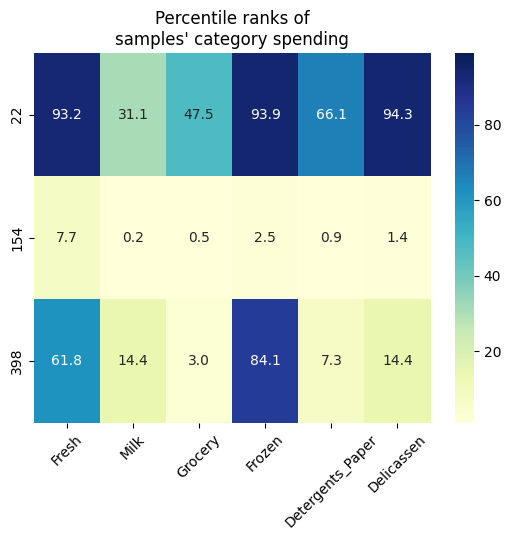

In [9]:
# look at percentile ranks
#pcts = 100. * data.rank(axis=0, pct=True).iloc[indices].round(decimals=3)
pcts = 100. * data.rank(axis=0, pct=True).iloc[indices].round(decimals=3)
# visualize percentiles with heatmap

sns.heatmap(pcts, annot=True, vmin=1, vmax=99, fmt='.1f', cmap='YlGnBu')
plt.title('Percentile ranks of\nsamples\' category spending')
plt.xticks(rotation=45, ha='center');

One interesting thought to consider is if one (or more) of the six product categories is actually relevant for understanding customer purchasing. That is to say, is it possible to determine whether customers purchasing some amount of one category of products will necessarily purchase some proportional amount of another category of products? We can make this determination quite easily by training a supervised regression learner on a subset of the data with one feature removed, and then score how well that model can predict the removed feature.

In [10]:
# Import libraries for Decision Tree Regressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

# Remove column Milk
new_data = data.drop('Milk',axis=1)

In [11]:
# Split the data into training and testing sets(0.25) using the given feature as the target
# Set a random state.
X_train, X_test, y_train, y_test = train_test_split(new_data, data['Milk'], test_size=0.25, random_state=1)

# Create a decision tree regressor and fit it to the training set
regressor =  DecisionTreeRegressor(random_state=1)
regressor.fit(X_train, y_train)

# Report the score of the prediction using the testing set
score = regressor.score(X_test, y_test)
print(score)

0.5158499438066617


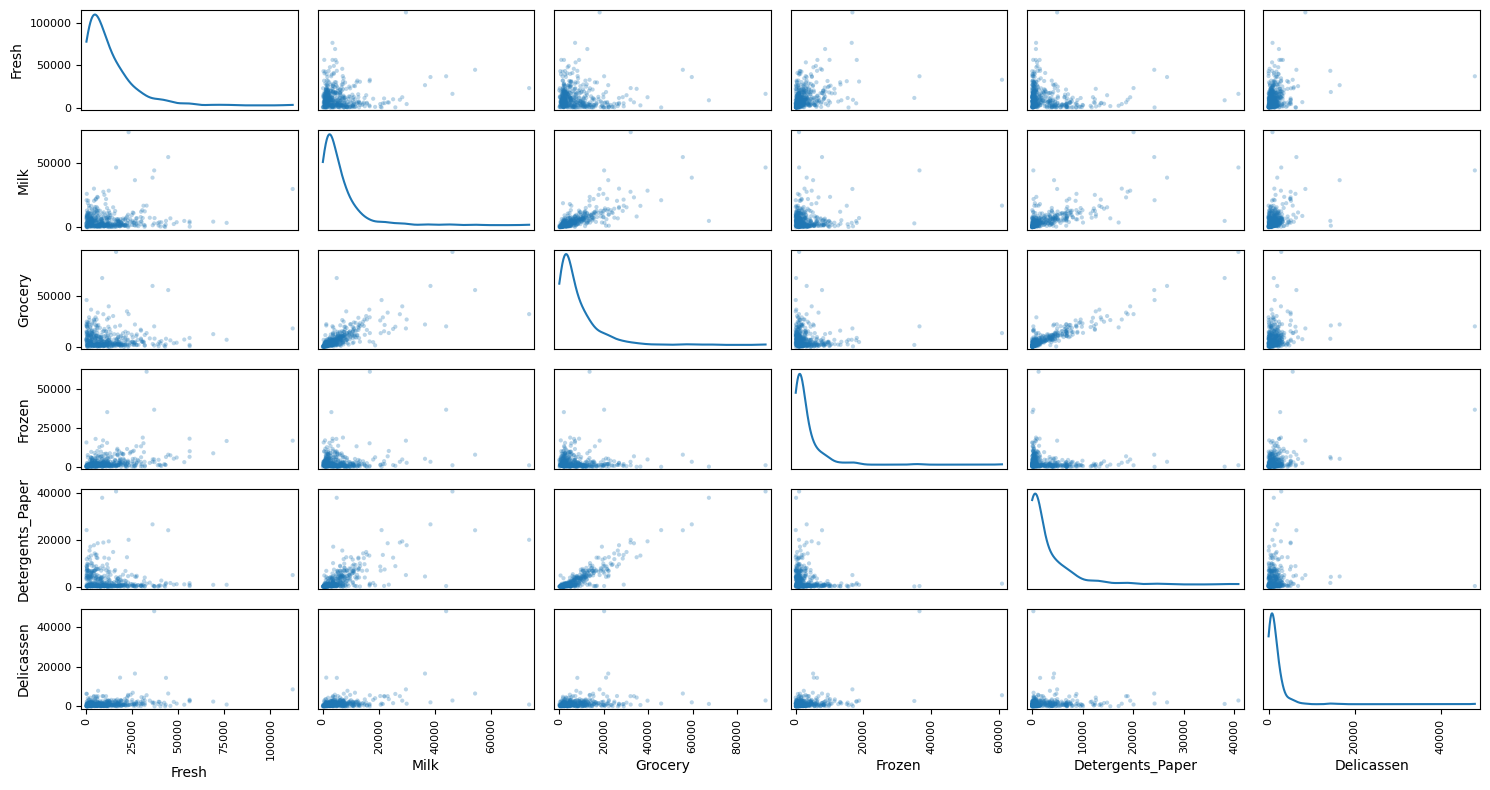

In [12]:
pd.plotting.scatter_matrix(data, alpha=0.3,figsize=(15,8),diagonal='kde' )
plt.tight_layout() # To avoid overlapping of plot

Milk showed some signs of correlation for about half of the features it was compared to which aligns with our earlier prediction. The pair of features with the highest correlation are Detergents_Paper and Grocery which intuitively makes sense as many people shop for both when they go "grocery shopping." One other visible point to note is how many of the points are around 0 for features compared to Delicatessen. The data for all of these features are right-skewed with many points hovering at the origin or near it and long tails.

Data Preprocessing

Now we will start to preprocess the data to create a better representation of customers by performing a scaling on the data and detecting (and optionally removing) outliers. Preprocessing data is often times a critical step in assuring that results we obtain from your analysis are significant and meaningful.

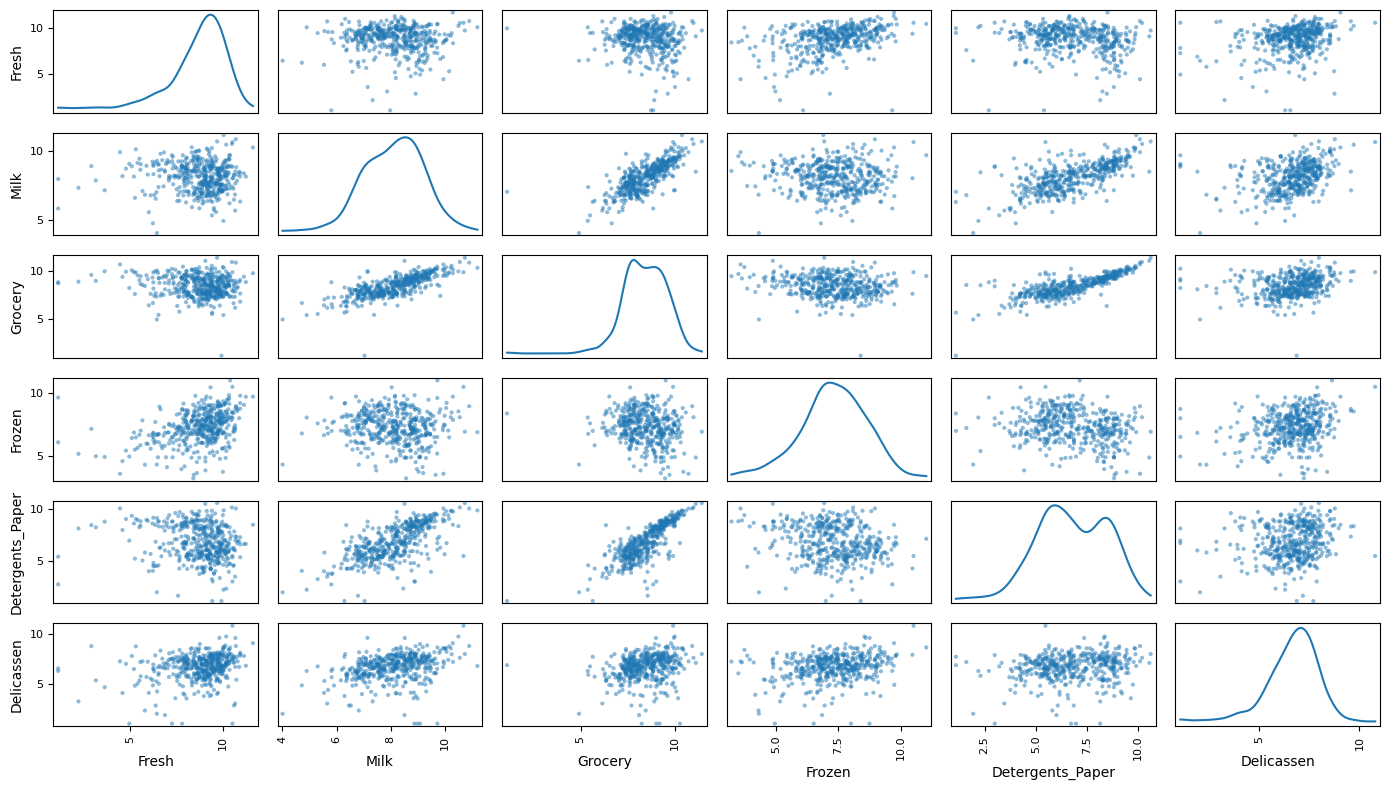

In [13]:
# Scale the data using the natural logarithm
log_data = np.log(data.copy())

# Scale the sample data using the natural logarithm
log_samples = np.log(samples)

# Produce a scatter matrix for each pair of newly-transformed features
pd.plotting.scatter_matrix(log_data, alpha=0.5, figsize=(14,8),diagonal='kde')
plt.tight_layout()

Observation

Observation
After applying a natural logarithm scaling to the data, the distribution of each feature appears much more normal. For any pairs of features you may have identified earlier as being correlated, observe here whether that correlation is still present (and whether it is now stronger or weaker than before)

In [14]:
# Let's compare the original sample data to the log-transformed sample data
print("Original chosen samples of wholesale customers dataset:")
display(samples)

# Display the log-transformed sample data
print("Log-transformed samples of wholesale customers dataset:")
display(log_samples)

Original chosen samples of wholesale customers dataset:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,31276,1917,4469,9408,2381,4334
1,622,55,137,75,7,8
2,11442,1032,582,5390,74,247


Log-transformed samples of wholesale customers dataset:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,10.350606,7.558517,8.404920,9.149316,7.775276,8.374246
1,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
2,9.345046,6.939254,6.366470,8.592301,4.304065,5.509388


Implementation: Outlier Detection

Detecting outliers in the data is extremely important in the data preprocessing step of any analysis. The presence of outliers can often skew results which take into consideration these data points. There are many "rules of thumb" for what constitutes an outlier in a dataset. Here, we will use Tukey's Method for identfying outliers: An outlier step is calculated as 1.5 times the interquartile range (IQR). A data point with a feature that is beyond an outlier step outside of the IQR for that feature is considered abnormal.

In [15]:
# For each feature find the data points with extreme high or low values
for feature in log_data.keys():

    # Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(log_data, 25)

    # Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(log_data, 75)

    # Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = (Q3 - Q1) * 1.5
    
# Display the outliers
    print("Data points considered outliers for the feature '{}':".format(feature))
    display(log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))])
    
    # Select the indices for data points you wish to remove
outliers  = [66, 75, 338, 142, 154, 289]

# Remove the outliers, if any were specified
good_data = log_data.drop(log_data.index[outliers]).reset_index(drop = True)

Data points considered outliers for the feature 'Fresh':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
95,1.098612,7.979339,8.740657,6.086775,5.407172,6.563856
96,3.135494,7.869402,9.001839,4.976734,8.262043,5.379897
218,2.890372,8.923191,9.629380,7.158514,8.475746,8.759669
338,1.098612,5.808142,8.856661,9.655090,2.708050,6.309918


Data points considered outliers for the feature 'Milk':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen


Data points considered outliers for the feature 'Grocery':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437


Data points considered outliers for the feature 'Frozen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
38,8.431853,9.663261,9.723703,3.496508,8.847360,6.070738
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
420,8.402007,8.569026,9.490015,3.218876,8.827321,7.239215


Data points considered outliers for the feature 'Detergents_Paper':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
122,9.410174,5.303305,5.501258,7.596392,3.218876,6.756932
142,10.519646,8.875147,9.018332,8.004700,2.995732,1.098612
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
161,9.428190,6.291569,5.645447,6.995766,1.098612,7.711101
177,9.453992,8.899731,8.419139,7.468513,2.995732,7.875119
204,7.578657,6.792344,8.561401,7.232010,1.609438,7.191429
237,9.835851,8.252707,6.385194,8.441176,3.332205,7.102499
289,10.663966,5.655992,6.154858,7.235619,3.465736,3.091042
338,1.098612,5.808142,8.856661,9.655090,2.708050,6.309918


Data points considered outliers for the feature 'Delicassen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
109,7.248504,9.724899,10.274568,6.511745,6.728629,1.098612
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
137,8.034955,8.997147,9.021840,6.493754,6.580639,3.583519
142,10.519646,8.875147,9.018332,8.004700,2.995732,1.098612
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
184,5.789960,6.822197,8.457443,4.304065,5.811141,2.397895
187,7.798933,8.987447,9.192075,8.743372,8.148735,1.098612
203,6.368187,6.529419,7.703459,6.150603,6.860664,2.890372
233,6.871091,8.513988,8.106515,6.842683,6.013715,1.945910


Feature Transformation
In this section we will use principal component analysis (PCA) to draw conclusions about the underlying structure of the wholesale customer data. Since using PCA on a dataset calculates the dimensions which best maximize variance, we will find which compound combinations of features best describe customers.

Implementation: PCA
Now that the data has been scaled to a more normal distribution and has had any necessary outliers removed, we can go ahead and apply PCA to the good_data to discover which dimensions about the data best maximize the variance of features involved. In addition to finding these dimensions, PCA will also report the explained variance ratio of each dimension — how much variance within the data is explained by that dimension alone. Note that a component (dimension) from PCA can be considered a new "feature" of the space, however it is a composition of the original features present in the data.

In [16]:
from sklearn.decomposition import PCA

# Apply PCA by fitting the good data with the same number of dimensions as features
pca = PCA(n_components=6)
pca.fit(good_data)

# Transform log_samples using the PCA fit above
pca_samples = pca.transform(log_samples)

In [17]:
print(pca.components_)

[[ 0.21392264 -0.39475187 -0.44010253  0.20691301 -0.74192568 -0.10700991]
 [-0.64381547 -0.18576705 -0.11241997 -0.50991866 -0.08727179 -0.52030817]
 [-0.62720898  0.06414633 -0.03758881  0.08806961 -0.2720558   0.72063209]
 [-0.38236666  0.01374015  0.00569147  0.82912144  0.16410724 -0.37309651]
 [ 0.01137444  0.74284767  0.30735768 -0.01142146 -0.54234253 -0.24354333]
 [-0.00374186 -0.50352295  0.83531878  0.04290564 -0.2164462  -0.00182239]]


In [18]:
print(pca.explained_variance_)

[4.52563843 2.78067608 1.13683913 1.0169372  0.46737122 0.19773848]


In [19]:
pca_samples

array([[ 0.10386282, -2.80192323,  0.0745543 ,  0.44428191, -1.37505936,
         0.10828145],
       [ 6.20014668,  7.01961701, -0.94091359, -0.74060463, -0.37897464,
         0.06591127],
       [ 3.79702755,  0.26725311, -0.42705142,  0.84604866,  0.11361609,
        -0.5462458 ]])